# AutoML Classification

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

This is a copy of the test set of the **UCI ML hand-written digits datasets** http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where each class refers to a digit.



<img src="https://www.seewald.at/img/L/digits.gif">


## Documentation Azure ML service
> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## 1. Informations

As part of the setup you have already created an Azure ML `Workspace` object. <br> For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [60]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [61]:
import azureml.core
print("Version Azure ML Service :", azureml.core.VERSION)

Version Azure ML Service : 1.0.74


In [62]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

## 2. Connexion workspace Azure ML service

In [63]:
ws = Workspace.from_config()

experiment_name = 'workshop2'
project_folder = './sample_projects/workshop2'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
SDK version,1.0.74
Workspace Name,workshopml
Resource Group,workshopmlRG
Location,northeurope
Project Directory,./sample_projects/workshop2
Experiment Name,workshop2


## 3. Chargement des données

This uses scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.

In [64]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

In [65]:
print(digits.data.shape)

(1797, 64)


## 4. Configuration AutoML



In [66]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 5, # Temps max par itération
                             experiment_timeout_minutes = 5, # Temps max pour le process AutoML
                             enable_early_stopping=True, # Sortie si pas d'amélioration de la métrique
                             #iterations = 10,           # Possibilité de définir le nombre d'itérations max
                             n_cross_validations = 3,    # Nombre de validation croisée
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


## 5. AutoML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

`AUC_weighted` is the **metric** used.

In [67]:
%%time
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_d62b9716-907f-43c7-83d8-6e8443e8e7d6
Current status: DatasetCrossValidationSplit. Generating CV splits.

****************************************************************************************************
DATA GUARDRAILS SUMMARY:
For more details, use API: run.get_guardrails()

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Classes are balanced in the training data.

****************************************************************************************************
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************

In [68]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
workshop2,AutoML_d62b9716-907f-43c7-83d8-6e8443e8e7d6,automl,Running,Link to Azure Machine Learning studio,Link to Documentation


## 6. Exploration des résultats AutoML

### 6.1 Notebook Widget

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [69]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…


### 6.2 Métriques par itération


In [70]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
AUC_macro,0.99,1.00,1.00,0.99,1.00,1.00,1.00,0.99,0.98,1.00,...,0.97,0.99,0.98,1.00,1.00,1.00,1.00,0.99,1.00,0.98
AUC_micro,0.99,1.00,1.00,0.99,1.00,1.00,1.00,0.99,0.98,1.00,...,0.96,0.99,0.99,1.00,1.00,1.00,1.00,0.99,1.00,0.98
AUC_weighted,0.99,1.00,1.00,0.99,1.00,1.00,1.00,0.99,0.98,1.00,...,0.97,0.99,0.98,1.00,1.00,1.00,1.00,0.99,1.00,0.98
accuracy,0.95,0.96,0.94,0.91,0.95,0.94,0.95,0.87,0.87,0.94,...,0.75,0.89,0.88,0.95,0.94,0.95,0.92,0.90,0.96,0.85
average_precision_score_macro,0.98,0.99,0.98,0.94,0.98,0.98,0.98,0.93,0.91,0.98,...,0.85,0.95,0.92,0.98,0.99,0.99,0.98,0.97,0.99,0.94
average_precision_score_micro,0.98,0.99,0.98,0.94,0.98,0.98,0.99,0.93,0.88,0.98,...,0.82,0.95,0.93,0.98,0.99,0.99,0.98,0.97,0.99,0.91
average_precision_score_weighted,0.98,0.99,0.98,0.94,0.98,0.98,0.98,0.93,0.91,0.98,...,0.85,0.95,0.92,0.98,0.99,0.99,0.98,0.97,0.99,0.94
balanced_accuracy,0.95,0.96,0.94,0.91,0.95,0.94,0.95,0.87,0.87,0.94,...,0.75,0.89,0.88,0.95,0.94,0.95,0.92,0.90,0.96,0.86
f1_score_macro,0.95,0.96,0.94,0.91,0.95,0.94,0.95,0.86,0.86,0.94,...,0.72,0.89,0.88,0.95,0.94,0.95,0.92,0.90,0.96,0.83
f1_score_micro,0.95,0.96,0.94,0.91,0.95,0.94,0.95,0.87,0.87,0.94,...,0.75,0.89,0.88,0.95,0.94,0.95,0.92,0.90,0.96,0.85


## 7. Récupération du meilleur modèle

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [71]:
best_run, fitted_model = local_run.get_output()

print(best_run)
print()
print(fitted_model)

Run(Experiment: workshop2,
Id: AutoML_d62b9716-907f-43c7-83d8-6e8443e8e7d6_21,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('12', Pipeline(memory=None,
     steps=[('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('LightGBMClassifier', LightGBMClassifier(boosting_type='gbdt', clas...857142857142, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142]))])


In [72]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('12', Pipeline(memory=None,
     steps=[('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('LightGBMClassifier', LightGBMClassifier(boosting_type='gbdt', clas...857142857142, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142]))])>

In [73]:
fitted_model.steps

[('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                 estimators=[('12', Pipeline(memory=None,
       steps=[('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('LightGBMClassifier', LightGBMClassifier(boosting_type='gbdt', class_weight=None,
            colsample_bytree=0.8911111111111111, importance_type='split',
            learning_rate=0.0...mators=10, n_jobs=1,
             oob_score=True, random_state=None, verbose=0, warm_start=False))]))],
                 flatten_transform=None,
                 weights=[0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0.07142857142857142, 0.07142857142857142, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142]))]

### 7.1 Changement de la métrique AutoML


In [74]:
lookup_metric = "f1_score_weighted"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print("Meilleur modèle :")
print(best_run)
print()
print(fitted_model)

Meilleur modèle :
Run(Experiment: workshop2,
Id: AutoML_d62b9716-907f-43c7-83d8-6e8443e8e7d6_21,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('12', Pipeline(memory=None,
     steps=[('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('LightGBMClassifier', LightGBMClassifier(boosting_type='gbdt', clas...857142857142, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142]))])


Model from a Specific Iteration
Show the run and the model from the third iteration:

In [75]:
iteration = 3

my_run, my_model = local_run.get_output(iteration = iteration)
print("Modèle",iteration,"eme itération :")
print(my_run)
print()
print(my_model)

Modèle 3 eme itération :
Run(Experiment: workshop2,
Id: AutoML_d62b9716-907f-43c7-83d8-6e8443e8e7d6_3,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.runtime.model_wrappers.StandardScalerWrapper object at 0x7f9a18209748>), ('SGDClassifierWrapper', SGDClassifierWrapper(alpha=0.0001, class_weight='balanced', eta0=0.0001,
           fit_intercept=False, l1_ratio=0.3469387755102041,
           learning_rate='constant', loss='modified_huber', max_iter=1000,
           n_jobs=1, penalty='l2', power_t=0.2222222222222222,
           random_state=None, tol=0.01))])


## 8. Application du modèle

### 8.1 Chargement des données

In [76]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

### 8.2 Test
We will try to predict 2 digits and see how our model works.

4


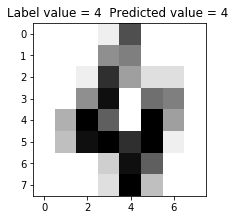

0


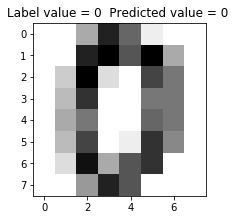

CPU times: user 501 ms, sys: 0 ns, total: 501 ms
Wall time: 373 ms


In [77]:
%%time
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">